# <center> Neural Networks and Deep Learning (CSCI 5922)</center>
# <center> Spring 2019 </center>

**Name: Payoj Jain**

## Goal

The goal of this assignment is to introduce neural networks in terms of ideas you are already familiar with:  linear regression and linear-threshold classification

## Dataset

You are given a dataset with 2 input variables ($x_1$, $x_2$) and an output variable ($y$).

In [1]:
from sklearn.datasets import make_regression
from matplotlib import pyplot as plt
import numpy as np
import os

# Load data
data = np.loadtxt(os.path.join('data', 'assign1_data.txt'))
X = data[:,:2]
y = data[:, 2]
z = data[:, 3]

# Concatenating bias to X
b = np.array([[1]]*X.shape[0])
X = np.concatenate((X,b),axis=1)

cost_updates = []
incorrect_updates = []

## Part 1

Write a program to find the least squares solution to $y = w_1 x_1 + w_2 x_2 + b$ for the above dataset. 

Complete the following function below and use it to answer questions (A) and (B). 

**Note:** Please do not change the interface of the given function.

In [2]:
def lms(X, y):
    """
    Finds the Least Mean Squares solution
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of output value 'y' (size : no of examples X 1)
    
    Returns
    -------
    w : solution array
    """

    from numpy.linalg import inv
    w = (inv((X.T@X))@X.T)@y
    return w

(A) Report the values of $w_1$, $w_2$, and $b$.

In [3]:
w = lms(X,y)
print("w1:", w[0], "w2:", w[1], "b:", w[2])

w1: -2.04424259514 w2: 3.99686016866 b: -0.924290811868


(B) What function or method did you use to find the least-squares solution?

> Closed form Normal Equation which is derived from $$ y = X^T \cdot w $$  The Normal equation is written as:  
$$ w = (X^T \cdot X)^{-1}X^T \cdot y$$


## Part 2

Using the LMS algorithm, write a program that determines the coefficients {w1,w2,b} via incremental updating, steepest descent, and multiple passes through the training data. You will need to experiment with updating rules (online, batch, minibatch), step sizes (i.e., learning rates), stopping criteria, etc. Experiment to find settings that lead to solutions with the fewest number of sweeps through the data.

Complete the following functions below and use them to answer questions (A), (B) and (C). You may find the shuffle function from scikit-learn useful. 

Use the following hyperparameters:

Learning rates = [0.001, 0.05, 0.01, 0.05, 0.1, 0.3]

MaxIter = [10, 50, 100, 500, 1000, 5000, 10000, 25000, 50000]

**Note:** Please do not change the interface of the given functions.

In [4]:
from sklearn.utils import shuffle


def cost_(X,y,w):
    """
    takes training example, labels and weights and compute the cost for a particular iteration
    
    Returns
    -------
    cost : Mean square error
    """
    num_of_training_samples = len(y)
    fx = X.dot(w.T)
    cost = (1/(2*num_of_training_samples))*np.sum(np.square(fx-y))
    return cost

def online_update(X, y, w, alpha = 0.01):
    """
    One iteration of the online update over the entire dataset (one sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    alpha : Learning rate, default 0.01
    
    Returns
    -------
    w : Coefficients of the classifier (after updating)
    cost : average cost for one iteration
    """
    cost = 0
    for i,x in enumerate(X):
        
        fx = X[i].dot(w.T)
        w = w - alpha*(x*(fx - y[i]))
        cost += cost_(X,y,w)
    cost /= len(y)
    return w,cost

def batch_update(X, y, w, alpha = 0.01):
    """
    One iteration of the batch update.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    alpha : Learning rate, default 0.01
    
    Returns
    -------
    w : Coefficients of the classifier (after updating)
    cost : cost of 1 iteration
    """
    
    num_of_training_samples = X.shape[0]
    fx = X.dot(w.T)
    w = w - (1/num_of_training_samples)*alpha*(X.T@(fx - y))
    cost = cost_(X,y,w)
    return w, cost

def mini_batch_update(X, y, w, alpha, batch_size = 10):
    """
    One iteration of the mini-batch update over the entire dataset (one sweep of the dataset).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    alpha : Learning rate, default 0.01
    batch_size : size of the batch for gradient update
    
    Returns
    -------
    w : Coefficients of the classifier (after updating)
    cost: cost of 1 iteration
    """
    
    batches = int(X.shape[0]/batch_size)
    num_of_training_samples = X.shape[0]
    cost = 0
    for i in range(0,num_of_training_samples,batch_size):
        train_X = X[i:i+batch_size]
        train_y = y[i:i+batch_size]

        w,c = batch_update(train_X,train_y,w,alpha)
        cost += c
        
    cost = cost/batches
    
    return w,cost

def lms_grad_desc(X, y, maxIter, alpha, update, *batch_size):
    """
    Implements the LMS with gradient descent.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : Maximum number of iterations allowed
    alpha : Learning rate
    update : update function to utilize (one of online, batch, mini-batch)
    batch_size : number of examples in a batch (only useful when update = mini_batch_update)
    
    Returns
    -------
    w : Coefficients of the classifier (after updating)
    
    Note : *batch_size is an optional argument and only to be used when doing mini-batch Gradient Descent 
    """
    
    map = {"online":online_update,"batch":batch_update,"mini-batch":mini_batch_update}
    
    w = np.zeros(X[0].size)
    
    
#     w_updates = np.zeros(maxIter)
    for iter in range(maxIter):
        
        X,y = shuffle(X,y)
        if update == 'mini-batch':
            w,cost = map[update](X,y,w,alpha,batch_size[0])
        else:
            w,cost = map[update](X,y,w,alpha)
#         w_updates[iter] = w
        cost_updates.append(cost)
    
        if(iter >1 and abs(cost_updates[-1]-cost_updates[-2])/cost_updates[-2] < 0.001):
            break
            
    if update == "mini-batch":
        print("Batch size: "+str(batch_size[0]) +" Learning Rate: "+str(alpha)+" Epochs: "+str(iter)+" Maximum Iterations: "+str(maxIter)+" Error: "+str(cost_updates[iter]))
    else:
        print("Learning Rate: "+str(alpha)+" Epochs: "+str(iter)+" Maximum Iterations: "+str(maxIter)+" Error: "+str(cost_updates[iter]))

    return w

(A) Report the values of $w_1$, $w_2$, and $b$. 

In [5]:
w = lms_grad_desc(X,y,10000,0.1,"online")
print("w1:", w[0], "w2:", w[1], "b:", w[2])

Learning Rate: 0.1 Epochs: 39 Maximum Iterations: 10000 Error: 0.0209399747507
w1: -2.031591931 w2: 3.99999171962 b: -0.897943032625


In [6]:
w = lms_grad_desc(X,y,10000,0.1,"batch")
print("w1:", w[0], "w2:", w[1], "b:", w[2])

Learning Rate: 0.1 Epochs: 457 Maximum Iterations: 10000 Error: 0.0224333610603
w1: -1.973413552 w2: 3.79729431956 b: -0.856425664993


In [7]:
w = lms_grad_desc(X,y,10000,0.1,"mini-batch",10)
print("w1:", w[0], "w2:", w[1], "b:", w[2])

Batch size: 10 Learning Rate: 0.1 Epochs: 55 Maximum Iterations: 10000 Error: 0.582821331004
w1: -2.01515139963 w2: 3.8926694802 b: -0.89456133285


In [8]:
Learning_rates = [0.001, 0.05, 0.01, 0.05, 0.1, 0.3]
MaxIter = [10, 50, 100, 500, 1000, 5000, 10000, 25000, 50000]
batch_sizes = [5,10,20,25,50]
optimal_weights = []
updates = ["online","batch","mini-batch"]
for update in updates:
    print('----------------------------------------------------\n')
    print('\t\t\t'+update.upper())

    for alpha in Learning_rates:
        
        print("\n")
        print("------------------Learning rate : " + str(alpha)+"-------------\n")
        for i,maxIter in enumerate(MaxIter):
            
            if (update == "mini-batch"):
                for batch_size in batch_sizes:
                    cost_updates = []
                    w = lms_grad_desc(X,y,maxIter,alpha,update, batch_size)
            else:
                cost_updates = []
                w = lms_grad_desc(X,y,maxIter,alpha,update)
        optimal_weights.append(w)

----------------------------------------------------

			ONLINE


------------------Learning rate : 0.001-------------

Learning Rate: 0.001 Epochs: 9 Maximum Iterations: 10 Error: 0.634485590585
Learning Rate: 0.001 Epochs: 49 Maximum Iterations: 50 Error: 0.380187083514
Learning Rate: 0.001 Epochs: 99 Maximum Iterations: 100 Error: 0.205224835602
Learning Rate: 0.001 Epochs: 444 Maximum Iterations: 500 Error: 0.0216594164109
Learning Rate: 0.001 Epochs: 440 Maximum Iterations: 1000 Error: 0.0217661633278
Learning Rate: 0.001 Epochs: 443 Maximum Iterations: 5000 Error: 0.0216856561142
Learning Rate: 0.001 Epochs: 442 Maximum Iterations: 10000 Error: 0.0217168524809
Learning Rate: 0.001 Epochs: 446 Maximum Iterations: 25000 Error: 0.021612389193
Learning Rate: 0.001 Epochs: 444 Maximum Iterations: 50000 Error: 0.0216652648031


------------------Learning rate : 0.05-------------

Learning Rate: 0.05 Epochs: 9 Maximum Iterations: 10 Error: 0.021508939684
Learning Rate: 0.05 Epochs: 11 M

Batch size: 5 Learning Rate: 0.001 Epochs: 49 Maximum Iterations: 50 Error: 0.63119849567
Batch size: 10 Learning Rate: 0.001 Epochs: 49 Maximum Iterations: 50 Error: 0.674574685895
Batch size: 20 Learning Rate: 0.001 Epochs: 2 Maximum Iterations: 50 Error: 0.72466065399
Batch size: 25 Learning Rate: 0.001 Epochs: 2 Maximum Iterations: 50 Error: 0.724990116249
Batch size: 50 Learning Rate: 0.001 Epochs: 2 Maximum Iterations: 50 Error: 0.725583883874
Batch size: 5 Learning Rate: 0.001 Epochs: 99 Maximum Iterations: 100 Error: 0.554467454535
Batch size: 10 Learning Rate: 0.001 Epochs: 99 Maximum Iterations: 100 Error: 0.630787640832
Batch size: 20 Learning Rate: 0.001 Epochs: 2 Maximum Iterations: 100 Error: 0.724673757829
Batch size: 25 Learning Rate: 0.001 Epochs: 2 Maximum Iterations: 100 Error: 0.725002622128
Batch size: 50 Learning Rate: 0.001 Epochs: 2 Maximum Iterations: 100 Error: 0.72561811454
Batch size: 5 Learning Rate: 0.001 Epochs: 499 Maximum Iterations: 500 Error: 0.204311

Batch size: 5 Learning Rate: 0.01 Epochs: 99 Maximum Iterations: 100 Error: 0.068961182088
Batch size: 10 Learning Rate: 0.01 Epochs: 99 Maximum Iterations: 100 Error: 0.204772889812
Batch size: 20 Learning Rate: 0.01 Epochs: 99 Maximum Iterations: 100 Error: 0.378881492162
Batch size: 25 Learning Rate: 0.01 Epochs: 99 Maximum Iterations: 100 Error: 0.429628898274
Batch size: 50 Learning Rate: 0.01 Epochs: 99 Maximum Iterations: 100 Error: 0.55419995845
Batch size: 5 Learning Rate: 0.01 Epochs: 223 Maximum Iterations: 500 Error: 0.0214968571478
Batch size: 10 Learning Rate: 0.01 Epochs: 362 Maximum Iterations: 500 Error: 0.0254114105513
Batch size: 20 Learning Rate: 0.01 Epochs: 499 Maximum Iterations: 500 Error: 0.0450389298073
Batch size: 25 Learning Rate: 0.01 Epochs: 499 Maximum Iterations: 500 Error: 0.0687192854085
Batch size: 50 Learning Rate: 0.01 Epochs: 499 Maximum Iterations: 500 Error: 0.204186678496
Batch size: 5 Learning Rate: 0.01 Epochs: 223 Maximum Iterations: 1000 Err

Batch size: 50 Learning Rate: 0.1 Epochs: 99 Maximum Iterations: 100 Error: 0.0685225738709
Batch size: 5 Learning Rate: 0.1 Epochs: 32 Maximum Iterations: 500 Error: 0.0191609715665
Batch size: 10 Learning Rate: 0.1 Epochs: 78 Maximum Iterations: 500 Error: 0.0195141189182
Batch size: 20 Learning Rate: 0.1 Epochs: 92 Maximum Iterations: 500 Error: 0.0209735850255
Batch size: 25 Learning Rate: 0.1 Epochs: 122 Maximum Iterations: 500 Error: 0.0207241099457
Batch size: 50 Learning Rate: 0.1 Epochs: 196 Maximum Iterations: 500 Error: 0.0234202363744
Batch size: 5 Learning Rate: 0.1 Epochs: 47 Maximum Iterations: 1000 Error: 0.0190181765296
Batch size: 10 Learning Rate: 0.1 Epochs: 52 Maximum Iterations: 1000 Error: 0.0200486079871
Batch size: 20 Learning Rate: 0.1 Epochs: 99 Maximum Iterations: 1000 Error: 0.020587361707
Batch size: 25 Learning Rate: 0.1 Epochs: 101 Maximum Iterations: 1000 Error: 0.0228043174381
Batch size: 50 Learning Rate: 0.1 Epochs: 181 Maximum Iterations: 1000 Error

(B) What settings worked well for you:  online vs. batch vs. minibatch? What step size? How did you decide to terminate?

> __Observations:__ 
- Online gradient descend converges the fastest, mini-batch update follows second and Batch gradient descend is the slowest among the three to converge. 
- Mini-batch gives the minimum error. Batch update follows second.  

> __Online Update :__  
- Best Learning Rate = $0.1$
- Number of epochs to reach optimum solution: ~ $22$  
- Error: $0.0209473970304$  

> __Batch Update:__  
- Best Learning Rate = $0.05$  
- Number of epochs to reach optimum solution: ~ $181$  
- Error: $0.0201898138323$  

> __Mini Batch :__  
- Best Learning Rate = $0.3$  
- Batch size = $10$    
- Number of epochs to reach optimum solution: ~ $60$  
- Error: $0.0185828720358$  

> __STOPPING CRITERIA__  
The function stops updating the weights if the percentage in absolute change in error is less than 0.1%.  

(C) Make a graph of error on the entire data set as a function of epoch. An epoch is a complete sweep through all the data.

ONLINE UPDATE: 
Learning Rate: 0.1 Epochs: 10 Maximum Iterations: 1000 Error: 0.0209642199305
BATCH UPDATE : 
Learning Rate: 0.3 Epochs: 181 Maximum Iterations: 1000 Error: 0.0201898138323
MINI-BATCH UPDATE : 
Batch size: 10 Learning Rate: 0.3 Epochs: 34 Maximum Iterations: 1000 Error: 0.0191140512972


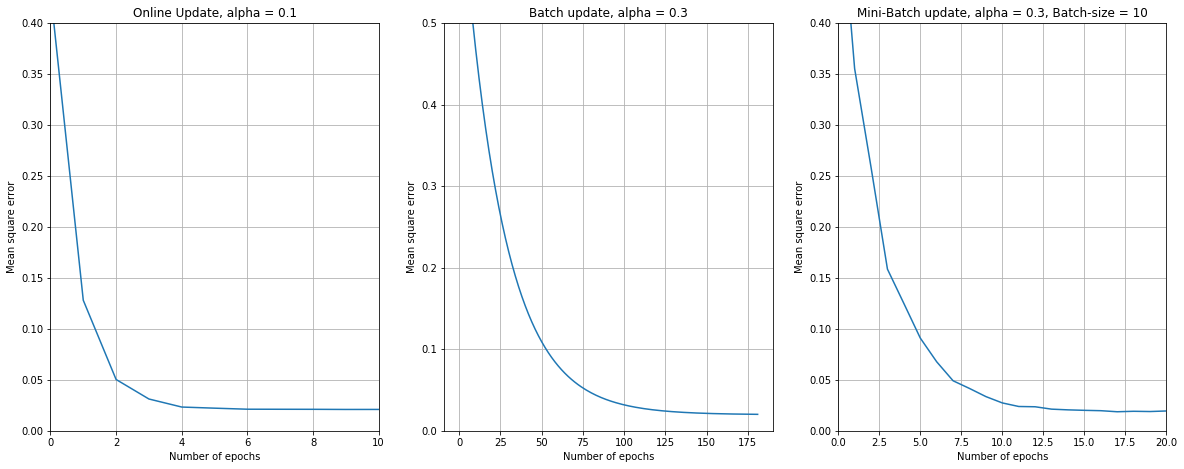

In [9]:
#ONLINE
cost_updates = []
print("ONLINE UPDATE: ")
lms_grad_desc(X,y,1000,0.1,"online")
fig, axs = plt.subplots(1,3)

axs[0].plot([i for i in range(len(cost_updates))],cost_updates)
axs[0].set_title("Online Update, alpha = 0.1")
axs[0].set_xlabel('Number of epochs')
axs[0].set_ylabel('Mean square error')
axs[0].set_ylim(0,0.4)
axs[0].set_xlim(0,10)
axs[0].grid(True)

#BATCH
cost_updates = []
print("BATCH UPDATE : ")
lms_grad_desc(X,y,1000,0.3,"batch")
axs[1].plot([i for i in range(len(cost_updates))],cost_updates)
axs[1].set_title("Batch update, alpha = 0.3")
axs[1].set_xlabel('Number of epochs')
axs[1].set_ylabel('Mean square error')
axs[1].set_ylim(0,0.5)
axs[1].grid(True)

#MINI-BATCH
cost_updates = []
print("MINI-BATCH UPDATE : ")
lms_grad_desc(X,y,1000,0.3,"mini-batch", 10)
axs[2].plot([i for i in range(len(cost_updates))],cost_updates)
axs[2].set_title("Mini-Batch update, alpha = 0.3, Batch-size = 10")
axs[2].set_xlabel('Number of epochs')
axs[2].set_ylabel('Mean square error')
axs[2].set_ylim(0,0.4)
axs[2].set_xlim(0,20)
axs[2].grid(True)

fig.set_size_inches(20, 7.5)
plt.show()

## Part 3

The data set from a regression problem can be converted into a classification problem simply by using the sign of (+ or -) as representing one of two classes. In the data set used in Part 1 and 2, you'll see a variable that represents this binary (0 or 1) class.

Use the perceptron learning rule to solve for the coefficients {$w_1$, $w_2$, $b$} of this classification problem.   

Two warnings: First, your solution to Part 3 should require only a few lines of code changed from the code you wrote for Part 2. Second, the Perceptron algorithm will not converge if there is no exact solution to the training data. It will jitter among coefficients that all yield roughly equally good solutions.

Complete the following functions below and use them to answer questions (A) and (B). 

**Note:** Please do not change the interface of the given functions.

In [10]:
def perceptron_update(X, y, w):
    """
    One iteration of the Perceptron update over the entire dataset (not just a single point).
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    w : array of coefficients from the previous iteration
    
    Returns
    -------
    w : Coefficients of the classifier (after updating)
    incorrect : Incorrectly classified examples
    """
    def relu(y):
        '''
        takes a value and returns 1 if the values is greater than 0 and 0 if not
        '''
        if y>0:
            return 1
        return 0
    
    incorrect = 0
    
    for i,x in enumerate(X):
        fx = X[i].dot(w.T)
        fx = relu(fx)
        w = w + alpha*(x*(y[i]- fx))
        incorrect += 0 if(fx == y[i]) else 1

    return w,incorrect

def perceptron(X, y, maxIter, alpha):
    """
    Implements the Perceptron algorithm.
    
    Parameters
    ----------
    X : NumPy array of features (size : no of examples X features)
    y : Numpy array of class labels (size : no of examples X 1)
    maxIter : The maximum number of iterations allowed 
    alpha : Learning Rate
    
    Returns
    -------
    w : Coefficients of the classifier
    incorrect : Incorrectly classified examples on termination
    """
    w = np.zeros(X[0].size)
    for iter in range(maxIter):
        X,y = shuffle(X,y)
        
        w, incorrect = perceptron_update(X,y,w)
        incorrect_updates.append(incorrect)

        if(iter > 100 and incorrect_updates[-2]>0 and abs(incorrect_updates[-1]-incorrect_updates[-2])/incorrect_updates[-2] < 0.001):
            break
    return w, incorrect

(A) Report the values of coefficients $w_1$, $w_2$, and $b$.

In [11]:
incorrect_updates = []
w,incorrect = perceptron(X,z,100,0.001)
print("w1:", w[0], "w2:", w[1], "b:", w[2])

w1: -3.04416 w2: 4.34781 b: -0.3


(B) Make a graph of the accuracy (% correct classification) on the training set as a function of epoch.

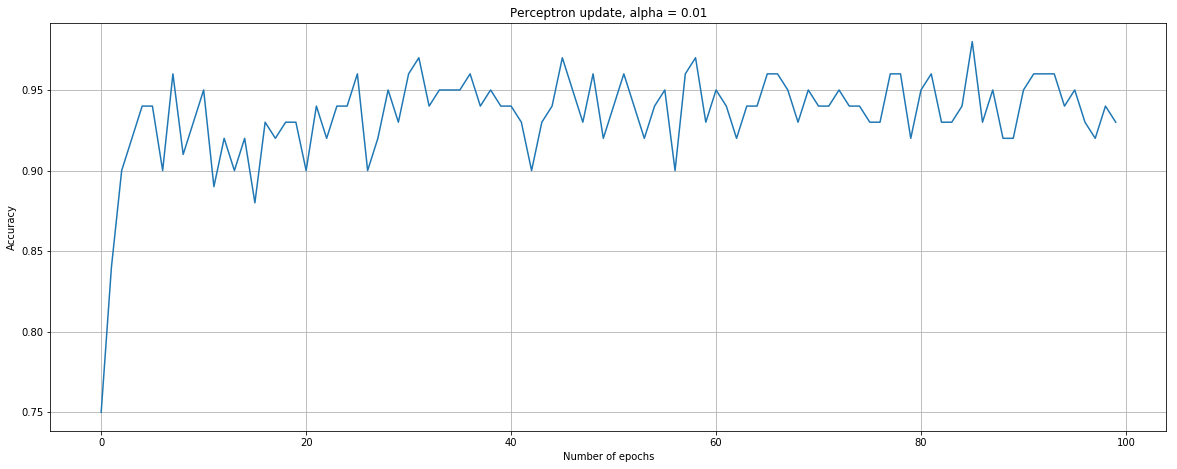

In [12]:
accuracy = 1-np.array(incorrect_updates)/len(z)
fig,axs = plt.subplots(1)
axs.plot([i for i in range(len(incorrect_updates))],accuracy)
axs.set_title("Perceptron update, alpha = 0.01")
axs.set_xlabel('Number of epochs')
axs.set_ylabel('Accuracy')
# axs.set_ylim(0,0.4)
# axs.set_xlim(0,20)
axs.grid(True)

fig.set_size_inches(20, 7.5)

## Part 4

In machine learning, we really want to train a model based on some data and then expect the model to do well on "out of sample" data. Try this with the code you wrote for Part 3:  Train the model on the first {5, 10, 25, 50, 75} examples in the data set and test the model on the final 25 examples.

Complete the following function below and use it to answer (A). 

**Note:** Please do not change the interface of the given function.

In [21]:
def classify(X, y, w):
    """
    Use this function to classify examples in the test set
    
    Parameters
    ----------
    X : Test set features
    y : Test set labels
    w : Perceptron coefficients
    
    Returns
    -------
    correct : number of correctly classified examples
    """
    def relu(y):
        if y>0:
            return 1
        return 0
    
    correct = 0
    
    for i,x in enumerate(X):
        fx = X[i].dot(w.T)
        fx = relu(fx)
        w = w + alpha*(x*(y[i]- fx))
        correct += 1 if(fx == y[i]) else 0

    return correct

How does performance on the test set vary with the amount of training data? Make a bar graph showing performance for each of the different training set sizes.

In [22]:
train_size = [5, 10, 25, 50, 75]
accuracy = []
alpha = 0.1
for size in train_size:
    train_X, train_Y = X[:size], z[:size]
    test_X, test_Y = X[-25:], z[-25:]
    w,incorrect = perceptron(train_X,train_Y,1000,alpha)
    correct = classify(test_X,test_Y,w)
    accuracy.append(correct/len(test_Y))

print(accuracy)

[0.72, 0.88, 0.92, 0.92, 0.92]


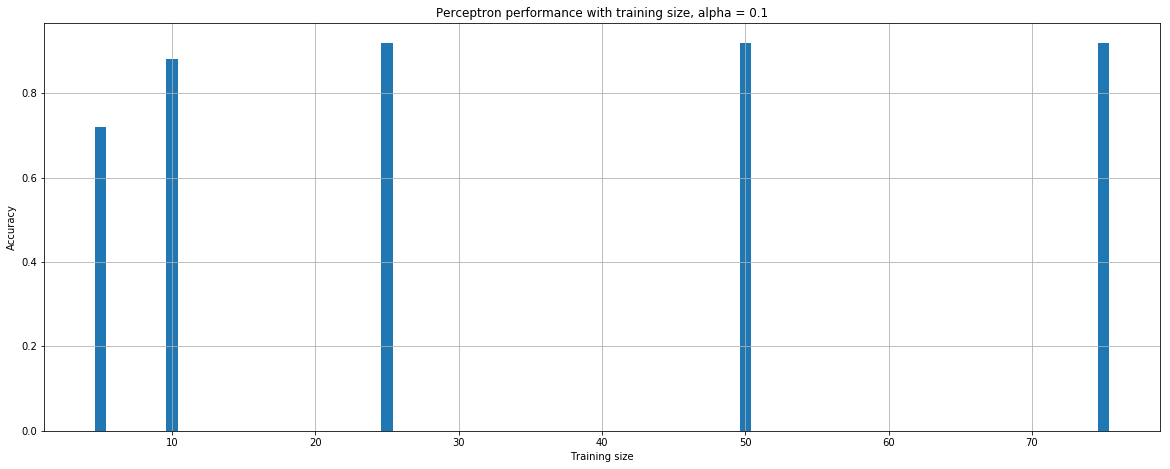

In [24]:
fig,axs = plt.subplots(1)
axs.bar(train_size,accuracy)
axs.set_title("Perceptron performance with training size, alpha = 0.1")
axs.set_xlabel('Training size')
axs.set_ylabel('Accuracy')
# axs.set_ylim(0,0.4)
# axs.set_xlim(0,20)
axs.grid(True)

fig.set_size_inches(20, 7.5)


>As we can see here that as the training size increases from 5 to 50 the test accuracy increases and becomes almost same with increase in training size